# Microservices Workload Prediction Experiment

This notebook demonstrates workload prediction using the Alibaba Microservices Trace v2022 dataset.

## Contents
1. Data Loading and Exploration
2. Data Analysis and Visualization
3. Data Preprocessing
4. Model Training and Evaluation
5. Results Comparison


# Environment

nvidia rtx 5090
cuda 13.0

## 1. Setup and Imports


In [1]:
# Standard libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Add project path
project_path = '/root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction'
if project_path not in sys.path:
    sys.path.insert(0, project_path)

# Import project modules
from config import DATA_CONFIG, MODEL_CONFIG, EXPERIMENT_CONFIG, create_output_dirs
from data_loader import DataModule, MSMetricsLoader, MSRTMCRLoader
from data_analysis import WorkloadAnalyzer, WorkloadVisualizer, analyze_dataset
from models import create_model, LSTMPredictor, GRUPredictor, TransformerPredictor
from trainer import WorkloadTrainer, run_experiment, compare_models

# Create output directories
create_output_dirs()

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print('Setup complete!')
print(f'Data root: {DATA_CONFIG.data_root}')
print(f'Output directory: {EXPERIMENT_CONFIG.output_dir}')


Setup complete!
Data root: /root/autodl-tmp/clusterdata/data
Output directory: /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs


## 2. Data Loading


In [2]:
# Initialize data module
dm = DataModule()

# Load MSMetrics data (adjust num_files based on your data)
# Each file covers 30 minutes, so 4 files = 2 hours of data
NUM_MSMETRICS_FILES = 4  # Adjust based on available data

print('Loading data...')
dm.load_data(num_msmetrics_files=NUM_MSMETRICS_FILES)


Loading data...
Loading MSMetrics data...
Loaded MSMetrics file 0/4
Total MSMetrics records: 55,950,419

MSMetrics Data Shape: (55950419, 6)
Unique microservices: 28,170
Timestamp range: 0 - 7140000


In [3]:
# Examine the loaded data
print('\nData shape:', dm.msmetrics_data.shape)
print('\nColumn names:', dm.msmetrics_data.columns.tolist())
print('\nData types:')
print(dm.msmetrics_data.dtypes)
print('\nFirst few rows:')
dm.msmetrics_data.head(10)



Data shape: (55950419, 6)

Column names: ['timestamp', 'msname', 'msinstanceid', 'nodeid', 'cpu_utilization', 'memory_utilization']

Data types:
timestamp               int64
msname                 object
msinstanceid           object
nodeid                 object
cpu_utilization       float64
memory_utilization    float64
dtype: object

First few rows:


,timestamp,msname,msinstanceid,nodeid,cpu_utilization,memory_utilization
0,300000,MS_68185,MS_68185_POD_91,NODE_20236,0.172378,0.662361
1,420000,MS_25215,MS_25215_POD_372,NODE_36528,0.085708,0.432862
2,720000,MS_31285,MS_31285_POD_916,NODE_23966,0.445229,0.572093
3,780000,MS_42019,MS_42019_POD_38,NODE_34880,0.091057,0.529339
4,900000,MS_9482,MS_9482_POD_332,NODE_45529,0.177660,0.642626
5,900000,MS_35322,MS_35322_POD_870,NODE_14735,0.134958,0.734253
6,1020000,MS_11349,MS_11349_POD_3,NODE_8635,0.042087,0.427744
7,1080000,MS_42518,MS_42518_POD_50,NODE_4918,0.116525,0.858788
8,1320000,MS_47100,MS_47100_POD_73,NODE_4804,0.191792,0.666632
9,1440000,MS_42222,MS_42222_POD_893,NODE_38530,0.145036,0.416571


In [4]:
# Basic statistics
print('Basic statistics:')
dm.msmetrics_data.describe()


Basic statistics:


,timestamp,cpu_utilization,memory_utilization
count,5.595042e+07,5.595042e+07,5.595042e+07
mean,3.569999e+06,1.293309e-01,6.019895e-01
std,2.078388e+06,1.077045e-01,1.793122e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.740000e+06,6.047500e-02,5.082580e-01
50%,3.600000e+06,9.885857e-02,6.403873e-01
75%,5.340000e+06,1.622500e-01,7.185855e-01
max,7.140000e+06,1.000000e+00,9.988585e-01


## 3. Data Analysis and Visualization


In [5]:
# Initialize analyzer and visualizer
analyzer = WorkloadAnalyzer()
visualizer = WorkloadVisualizer()

# Run comprehensive analysis
stats, service_stats, temporal = analyze_dataset(dm.msmetrics_data)


WORKLOAD DATA ANALYSIS

1. Basic Statistics
----------------------------------------
                cpu_utilization  memory_utilization
count              5.595042e+07        5.595042e+07
mean               1.293309e-01        6.019895e-01
std                1.077045e-01        1.793122e-01
min                0.000000e+00        0.000000e+00
25%                6.047500e-02        5.082580e-01
50%                9.885857e-02        6.403873e-01
75%                1.622500e-01        7.185855e-01
max                1.000000e+00        9.988585e-01
skewness           2.416205e+00       -1.082435e+00
kurtosis           8.891657e+00        1.224013e+00
non_zero_ratio     9.999711e-01        9.999888e-01

2. Service Statistics (Top 10)
----------------------------------------
          cpu_utilization_mean  cpu_utilization_std  cpu_utilization_min  cpu_utilization_max  cpu_utilization_count  memory_utilization_mean  memory_utilization_std  memory_utilization_min  memory_utilization_max
msna

In [6]:
# Get top microservices by data volume
top_services = dm.get_top_services(20)
print('Top 20 microservices by data points:')
for i, (svc, count) in enumerate(top_services, 1):
    print(f'  {i}. {svc}: {count:,} records')


Top 20 microservices by data points:
  1. MS_6945: 922,347 records
  2. MS_43157: 239,520 records
  3. MS_42222: 222,240 records
  4. MS_66711: 203,993 records
  5. MS_19988: 199,673 records
  6. MS_29860: 191,879 records
  7. MS_48534: 189,960 records
  8. MS_10489: 185,994 records
  9. MS_491: 179,387 records
  10. MS_73317: 177,839 records
  11. MS_27721: 172,919 records
  12. MS_38464: 170,640 records
  13. MS_70053: 170,269 records
  14. MS_63360: 166,676 records
  15. MS_72474: 156,000 records
  16. MS_68948: 155,996 records
  17. MS_21035: 151,073 records
  18. MS_57387: 150,711 records
  19. MS_27381: 143,886 records
  20. MS_53782: 143,879 records


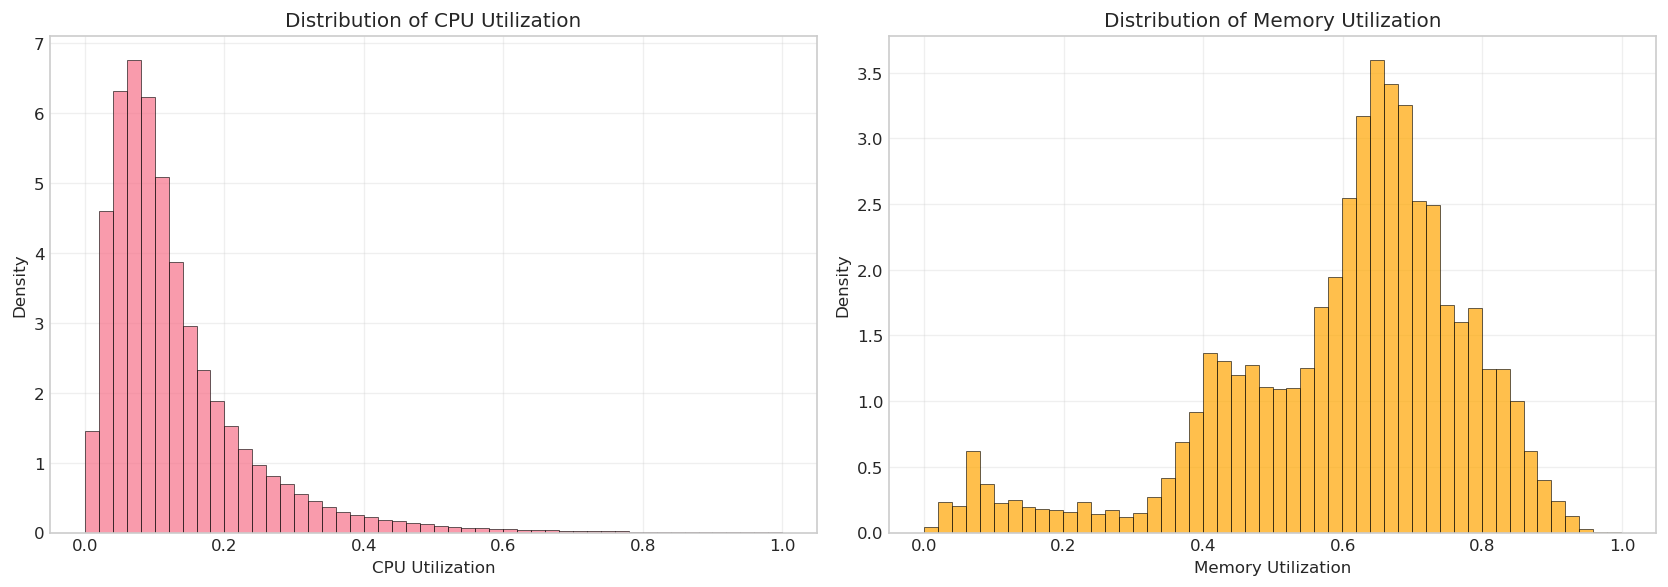

In [7]:
# Visualize distribution of CPU and memory utilization
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120)

# CPU utilization distribution
axes[0].hist(dm.msmetrics_data['cpu_utilization'].dropna(), bins=50, 
             density=True, alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('CPU Utilization')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of CPU Utilization')
axes[0].grid(True, alpha=0.3)

# Memory utilization distribution
axes[1].hist(dm.msmetrics_data['memory_utilization'].dropna(), bins=50,
             density=True, alpha=0.7, edgecolor='black', linewidth=0.5, color='orange')
axes[1].set_xlabel('Memory Utilization')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Memory Utilization')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(EXPERIMENT_CONFIG.figures_path, 'utilization_distribution.png'), dpi=150)
plt.show()


## 4. Prepare Data for Prediction


In [8]:
# Select a microservice for prediction
# Choose one with sufficient data points
MIN_DATA_POINTS = 200

# Find services with enough data
service_candidates = []
for svc, count in top_services:
    if count >= MIN_DATA_POINTS:
        service_candidates.append((svc, count))

print(f'Found {len(service_candidates)} services with >= {MIN_DATA_POINTS} data points')

if service_candidates:
    # Select the service with most data
    selected_service = service_candidates[0][0]
    print(f'\nSelected service for prediction: {selected_service}')
    print(f'Data points: {service_candidates[0][1]:,}')
else:
    print('No suitable service found. Please load more data.')


Found 20 services with >= 200 data points

Selected service for prediction: MS_6945
Data points: 922,347


In [9]:
# Prepare time series data for the selected service
if 'selected_service' in dir():
    ts_data = dm.prepare_service_data(
        selected_service,
        features=['cpu_utilization', 'memory_utilization'],
        normalize=True
    )
    
    if ts_data is not None:
        print(f'Time series shape: {ts_data.shape}')
        print(f'Features: {ts_data.columns.tolist()}')
        print(f'\nTime series statistics:')
        print(ts_data.describe())
    else:
        print('Failed to prepare time series data')


Time series shape: (120, 2)
Features: ['cpu_utilization', 'memory_utilization']

Time series statistics:
       cpu_utilization  memory_utilization
count       120.000000          120.000000
mean          0.362783            0.461857
std           0.190830            0.230202
min           0.000000            0.000000
25%           0.229570            0.254234
50%           0.344856            0.501842
75%           0.458087            0.561269
max           1.000000            1.000000


In [10]:
# Create DataLoaders
if 'ts_data' in dir() and ts_data is not None:
    print('Creating DataLoaders...')
    print(f'Sequence length: {MODEL_CONFIG.seq_length}')
    print(f'Prediction horizon: {MODEL_CONFIG.pred_length}')
    print(f'Batch size: {MODEL_CONFIG.batch_size}')
    
    train_loader, val_loader, test_loader = dm.create_dataloaders(
        ts_data.values,
        target_idx=0  # Predict CPU utilization
    )
    
    # Verify data shapes
    for x, y in train_loader:
        print(f'\nBatch shapes:')
        print(f'  Input (X): {x.shape}')
        print(f'  Target (Y): {y.shape}')
        break


Creating DataLoaders...
Sequence length: 12
Prediction horizon: 1
Batch size: 64
Train samples: 72
Val samples: 6
Test samples: 6

Batch shapes:
  Input (X): torch.Size([64, 12, 2])
  Target (Y): torch.Size([64, 1])


## 5. Model Training


In [11]:
# Check for GPU availability and compatibility
import torch

def check_gpu_compatibility():
    """Check if GPU is available and compatible with PyTorch."""
    print("=" * 60)
    print("GPU COMPATIBILITY CHECK")
    print("=" * 60)
    
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        
        # Test if CUDA actually works
        try:
            test_tensor = torch.zeros(1).cuda()
            test_result = test_tensor + 1
            del test_tensor, test_result
            print("\n✓ CUDA test passed! GPU can be used.")
            return 'cuda'
        except RuntimeError as e:
            print(f"\n✗ CUDA test failed: {e}")
            print("\nNote: Your GPU (RTX 5090) uses Blackwell architecture which may")
            print("require PyTorch 2.5+ with CUDA 13 support. Using CPU instead.")
            return 'cpu'
    else:
        print("\nNo CUDA-capable GPU detected. Using CPU.")
        return 'cpu'

# Run compatibility check
recommended_device = check_gpu_compatibility()
print(f"\nRecommended device: {recommended_device}")

# Set device for this notebook
device = torch.device(recommended_device)
print(f"Using device: {device}")


GPU COMPATIBILITY CHECK
PyTorch version: 2.10.0.dev20251207+cu128
CUDA available: True
CUDA version: 12.8


GPU: NVIDIA GeForce RTX 5090
GPU Memory: 33.67 GB

✓ CUDA test passed! GPU can be used.

Recommended device: cuda
Using device: cuda


In [12]:
# Train LSTM model
if 'train_loader' in dir():
    input_size = ts_data.shape[1]  # Number of features
    output_size = MODEL_CONFIG.pred_length
    
    print(f'Input size: {input_size}')
    print(f'Output size: {output_size}')
    
    # Run LSTM experiment
    lstm_results = run_experiment(
        model_type='lstm',
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        input_size=input_size,
        output_size=output_size,
        num_epochs=30  # Adjust as needed
    )


Input size: 2
Output size: 1

Running Experiment: LSTM
Model parameters: 54,913
Using device: cuda
Starting Training
  Epochs: 30
  Batch size: 64
  Learning rate: 0.001
Model saved to /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/models/best_model.pt
Epoch [1/30] Train Loss: 0.090860 Val Loss: 0.013193 Train MAE: 0.275773 Val MAE: 0.095520 Time: 0.30s
Model saved to /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/models/best_model.pt
Model saved to /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/models/best_model.pt
Model saved to /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/models/best_model.pt
Epoch [10/30] Train Loss: 0.019582 Val Loss: 0.030309 Train MAE: 0.117499 Val MAE: 0.161893 Time: 0.01s

Early stopping at epoch 14

Training completed in 0.42s
Best validation loss: 0.004183 at epoch 4

Test Evaluation

In [13]:
# Train GRU model
if 'train_loader' in dir():
    gru_results = run_experiment(
        model_type='gru',
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        input_size=input_size,
        output_size=output_size,
        num_epochs=30
    )



Running Experiment: GRU
Model parameters: 40,129
Using device: cuda
Starting Training
  Epochs: 30
  Batch size: 64
  Learning rate: 0.001
Model saved to /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/models/best_model.pt
Epoch [1/30] Train Loss: 0.122654 Val Loss: 0.025987 Train MAE: 0.317115 Val MAE: 0.148079 Time: 0.01s
Model saved to /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/models/best_model.pt
Model saved to /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/models/best_model.pt
Epoch [10/30] Train Loss: 0.024207 Val Loss: 0.043424 Train MAE: 0.123603 Val MAE: 0.198390 Time: 0.01s

Early stopping at epoch 13

Training completed in 0.12s
Best validation loss: 0.005001 at epoch 3

Test Evaluation Results:
----------------------------------------
  MSE: 0.039675
  RMSE: 0.199186
  MAE: 0.178056
  MAPE: 258.915192
  R2: -2.123776
Training history plot 

In [14]:
# Train Attention-LSTM model
if 'train_loader' in dir():
    attention_results = run_experiment(
        model_type='attention_lstm',
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        input_size=input_size,
        output_size=output_size,
        num_epochs=30
    )



Running Experiment: ATTENTION_LSTM
Model parameters: 57,026
Using device: cuda
Starting Training
  Epochs: 30
  Batch size: 64
  Learning rate: 0.001
Model saved to /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/models/best_model.pt
Epoch [1/30] Train Loss: 0.245801 Val Loss: 0.081045 Train MAE: 0.476967 Val MAE: 0.277451 Time: 0.04s
Model saved to /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/models/best_model.pt
Model saved to /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/models/best_model.pt
Model saved to /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/models/best_model.pt
Model saved to /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/models/best_model.pt
Model saved to /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/model

## 6. Results Comparison


In [15]:
# Compare all results
results_list = []

if 'lstm_results' in dir():
    results_list.append(lstm_results)
if 'gru_results' in dir():
    results_list.append(gru_results)
if 'attention_results' in dir():
    results_list.append(attention_results)

if results_list:
    comparison_df = pd.DataFrame(results_list)
    
    # Extract metrics
    for metric in ['mse', 'rmse', 'mae', 'mape', 'r2']:
        comparison_df[metric] = comparison_df['eval_metrics'].apply(lambda x: x[metric])
    
    comparison_df = comparison_df.drop(columns=['eval_metrics'])
    
    print('\n' + '=' * 60)
    print('MODEL COMPARISON')
    print('=' * 60)
    print(comparison_df.to_string())
    
    # Save comparison
    comparison_df.to_csv(
        os.path.join(EXPERIMENT_CONFIG.results_path, 'model_comparison.csv'),
        index=False
    )



MODEL COMPARISON
       model_type  num_params  best_val_loss  best_epoch       mse      rmse       mae        mape        r2
0            lstm       54913       0.004183           3  0.037067  0.192528  0.172517  250.558502 -1.918437
1             gru       40129       0.005001           2  0.039675  0.199186  0.178056  258.915192 -2.123776
2  attention_lstm       57026       0.004141           8  0.028256  0.168097  0.151638  220.566818 -1.224754


In [16]:
# Summary
print('=' * 60)
print('EXPERIMENT SUMMARY')
print('=' * 60)

print(f'\nDataset: Alibaba Microservices Trace v2022')
print(f'Target: {EXPERIMENT_CONFIG.target_variable}')
print(f'Sequence length: {MODEL_CONFIG.seq_length}')
print(f'Prediction horizon: {MODEL_CONFIG.pred_length}')

if 'comparison_df' in dir() and len(comparison_df) > 0:
    best_idx = comparison_df['rmse'].idxmin()
    best_model = comparison_df.loc[best_idx]
    
    print(f'\nBest Model: {best_model["model_type"].upper()}')
    print(f'  - RMSE: {best_model["rmse"]:.6f}')
    print(f'  - MAE: {best_model["mae"]:.6f}')
    print(f'  - R²: {best_model["r2"]:.6f}')

print(f'\nResults saved to: {EXPERIMENT_CONFIG.results_path}')
print(f'Figures saved to: {EXPERIMENT_CONFIG.figures_path}')


EXPERIMENT SUMMARY

Dataset: Alibaba Microservices Trace v2022
Target: cpu_utilization
Sequence length: 12
Prediction horizon: 1

Best Model: ATTENTION_LSTM
  - RMSE: 0.168097
  - MAE: 0.151638
  - R²: -1.224754

Results saved to: /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/results
Figures saved to: /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/figures
